# <font color='red'>Clustering Assignment</font>

**There will be some functions that start with the word "grader" ex: grader_actors(), grader_movies(), grader_cost1() etc, you should not change those function definition.<br><br>Every Grader function has to return True.**

**Please check [clustering assignment helper functions](https://drive.google.com/file/d/1V29KhKo3YnckMX32treEgdtH5r90DIjU/view?usp=sharing) notebook before attempting this assignment.**

*  Read graph from the given <font color='blue'>movie_actor_network.csv</font> (note that the graph is bipartite graph.)

*  Using stellergaph and gensim packages, get the dense representation(128dimensional vector) of every node in the graph. [Refer <font color='blue'>Clustering_Assignment_Reference.ipynb</font>]

* Split the dense representation into actor nodes, movies nodes.(Write you code in <font color='blue'>def data_split()</font>)


<br>

In [141]:
!pip install networkx==2.3

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [142]:
!pip install stellargraph

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [143]:
import networkx as nx
from networkx.algorithms import bipartite
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
import numpy as np
import warnings
warnings.filterwarnings("ignore")
import pandas as pd
# you need to have tensorflow 
from stellargraph.data import UniformRandomMetaPathWalk
from stellargraph import StellarGraph
from datetime import datetime

In [144]:
URL = 'https://drive.google.com/file/d/1F83qXMeHv3CIESBSj6jnXi0wdG2Kz3Ux/view?usp=sharing'
path = 'https://drive.google.com/uc?export=download&id='+URL.split('/')[-2]

data = pd.read_csv(path,index_col=False, names=['movie','actor'])
data.head()

,movie,actor
0,m1,a1
1,m2,a1
2,m2,a2
3,m3,a1
4,m3,a3


In [145]:
data.describe()

,movie,actor
count,9650,9650
unique,1292,3411
top,m1094,a973
freq,77,197


In [146]:
data[data.duplicated()]

,movie,actor


**There are no duplicated rows in the dataset**

In [147]:
# edge/link/relationship: connects two nodes in a graph
edges = [tuple(x) for x in data.values.tolist()]
print("Number of edges = ",len(edges))

Number of edges =  9650


In [148]:
B = nx.Graph() #Creating an empty graph with no nodes and edges 

#nodes/entities/vertex : objects that are connected by edges
B.add_nodes_from(data['movie'].unique(), bipartite=0, label='movie') #adding unique values from dataset as nodes to graph by function "add_nodes_from"
B.add_nodes_from(data['actor'].unique(), bipartite=1, label='actor')


B.add_edges_from(edges, label='acted') # adding edges to the graph by function "add_edges_from"

# info about bipartite graph:https://en.wikipedia.org/wiki/Bipartite_graph#:~:text=In%20the%20mathematical%20field%20of,the%20parts%20of%20the%20graph.

In [149]:
# generate connected components as subgraphs
A = list(nx.connected_component_subgraphs(B))[0]


In [150]:
print("number of nodes", A.number_of_nodes()) #contains  unique values of movie,actor
print("number of edges", A.number_of_edges()) # number of connections between movie and actor

number of nodes 4703
number of edges 9650


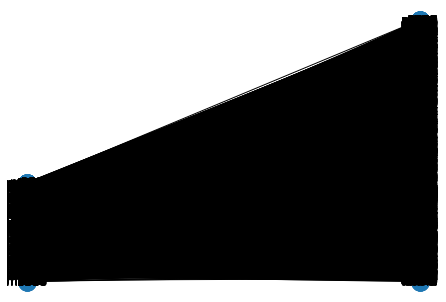

In [151]:
l, r = nx.bipartite.sets(A)
pos = {}

pos.update((node, (1, index)) for index, node in enumerate(l))
pos.update((node, (2, index)) for index, node in enumerate(r))
  
nx.draw(A, pos=pos, with_labels=True)
plt.show()

In [152]:
movies = []
actors = []
for i in A.nodes():
    if 'm' in i:
        movies.append(i)
    if 'a' in i:
        actors.append(i)
print('number of movies ', len(movies))
print('number of actors ', len(actors))

number of movies  1292
number of actors  3411


In [153]:

# Create the random walker
rw = UniformRandomMetaPathWalk(StellarGraph(A))

# specify the metapath schemas as a list of lists of node types.
metapaths = [
    ["movie", "actor", "movie"],
    ["actor", "movie", "actor"]
]

walks = rw.run(nodes=list(A.nodes()), # root nodes
               length=100,  # maximum length of a random walk
               n=1,        # number of random walks per root node 
               metapaths=metapaths
              )

print("Number of random walks: {}".format(len(walks)))
print('--'*15)
print("Sample random walk =")
print(walks[1])


Number of random walks: 4703
------------------------------
Sample random walk =
['m2', 'a2', 'm2', 'a2', 'm2', 'a2', 'm2', 'a1', 'm4', 'a10', 'm4', 'a1', 'm2', 'a1', 'm5', 'a13', 'm1206', 'a1381', 'm1231', 'a3446', 'm1231', 'a813', 'm176', 'a768', 'm181', 'a830', 'm185', 'a773', 'm188', 'a768', 'm212', 'a18', 'm5', 'a12', 'm1200', 'a969', 'm1195', 'a2271', 'm941', 'a1244', 'm593', 'a1629', 'm593', 'a1329', 'm1225', 'a3431', 'm1230', 'a3440', 'm1230', 'a3432', 'm1230', 'a3438', 'm1230', 'a1622', 'm1172', 'a1622', 'm1154', 'a1037', 'm356', 'a966', 'm515', 'a973', 'm755', 'a973', 'm681', 'a967', 'm719', 'a964', 'm792', 'a973', 'm1334', 'a1028', 'm693', 'a1016', 'm536', 'a1020', 'm1324', 'a205', 'm1325', 'a960', 'm294', 'a1003', 'm312', 'a977', 'm702', 'a1028', 'm306', 'a1025', 'm1349', 'a204', 'm1323', 'a3614', 'm1323', 'a3373', 'm1207', 'a3373', 'm1323', 'a3373', 'm1219', 'a3373']


In [154]:
from gensim.models import Word2Vec
model = Word2Vec(walks, size=128, window=5) #conveting each walk into vector format with 128 dimension

In [155]:
model.wv.vectors.shape  # 128-dimensional vector for each node in the graph

(4703, 128)

In [156]:
# Retrieve node embeddings and corresponding subjects
node_ids = model.wv.index2word  # list of node IDs
node_embeddings = model.wv.vectors  # numpy.ndarray of size number of nodes times embeddings dimensionality
node_targets = [ A.node[node_id]['label'] for node_id in node_ids]


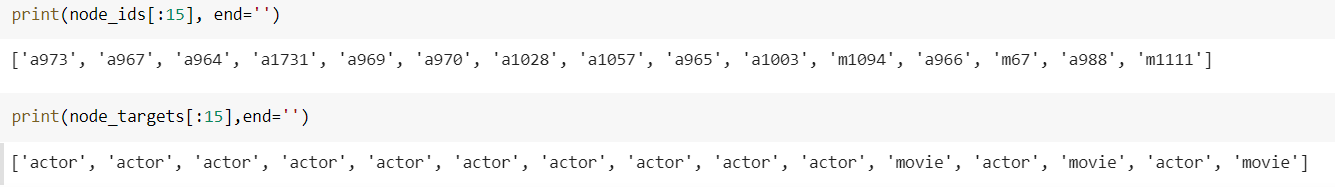

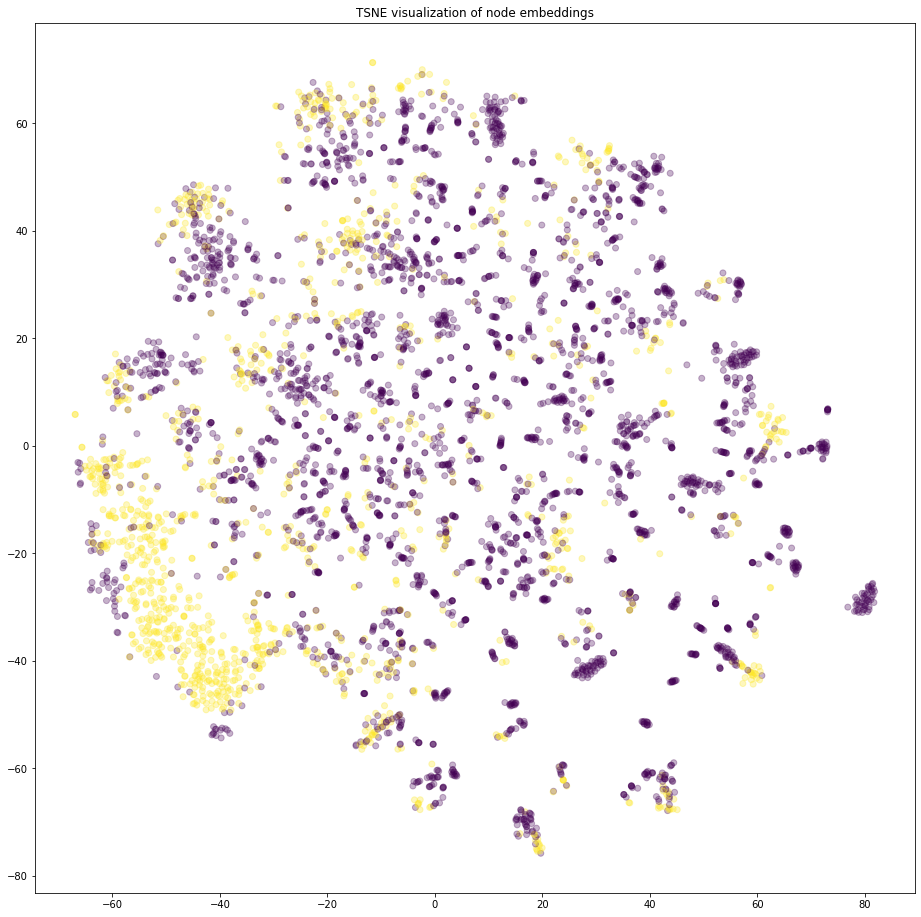

In [157]:
from sklearn.manifold import TSNE
transform = TSNE #PCA

trans = transform(n_components=2)
node_embeddings_2d = trans.fit_transform(node_embeddings)

import numpy as np
# draw the points

label_map = { l: i for i, l in enumerate(np.unique(node_targets))}
node_colours = [ label_map[target] for target in node_targets]

plt.figure(figsize=(20,16))
plt.axes().set(aspect="equal")
plt.scatter(node_embeddings_2d[:,0], 
            node_embeddings_2d[:,1], 
            c=node_colours, alpha=0.3)
plt.title('{} visualization of node embeddings'.format(transform.__name__))

plt.show()

In [158]:
# split the node_embeddings into actor_embeddings,movie_embeddings based on node_ids
# By using node_embedding and node_targets, we can extract actor_embedding and movie embedding
  # By using node_ids and node_targets, we can extract actor_nodes and movie nodes
start = datetime.now()
def data_split(node_ids,node_targets,node_embeddings):
    '''In this function, we will split the node embeddings into actor_embeddings , movie_embeddings '''
    actor_nodes,movie_nodes=[],[]
    actor_embeddings,movie_embeddings=[],[]

    for index,node in enumerate(node_ids):
      if 'a' in node:
        actor_nodes.append(node)
        actor_embeddings.append(node_embeddings[index])
      else :
        movie_nodes.append(node)  
        movie_embeddings.append(node_embeddings[index])
    return actor_nodes,movie_nodes,actor_embeddings,movie_embeddings

actor_nodes,movie_nodes,actor_embeddings,movie_embeddings = data_split(node_ids,node_targets,node_embeddings)

print("Time taken = ", datetime.now()-start)

Time taken =  0:00:00.004010


<font color='cyan'>Grader function - 1</font>

In [159]:
def grader_actors(data):
    assert(len(data)==3411)
    return True
grader_actors(actor_nodes)

True

<font color='cyan'>Grader function - 2</font>

In [160]:
def grader_movies(data):
    assert(len(data)==1292)
    return True
grader_movies(movie_nodes)

True

<font color='blue'>Calculating cost1</font>

Cost1 = $\frac{1}{N}\sum_{\text{each cluster i}}  \frac{\text{(number of nodes in the largest connected component in the graph with the actor nodes and its movie neighbours in cluster i)}}{\text{(total number of nodes in that cluster i)}}$ where N= number of clusters <br><br>
<br>

In [161]:
def cost1(graph,number_of_clusters):
    '''In this function, we will calculate cost1'''
    max_nodes = len(max(nx.connected_components(graph),key=len))
    total_nodes = graph.number_of_nodes()
    cost1= max_nodes/(total_nodes*number_of_clusters)
    return cost1

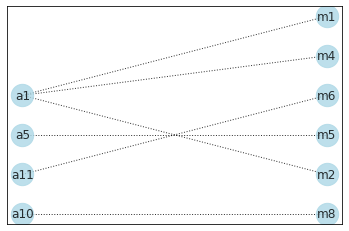

In [162]:
import networkx as nx
from networkx.algorithms import bipartite
graded_graph= nx.Graph()
graded_graph.add_nodes_from(['a1','a5','a10','a11'], bipartite=0) # Add the node attribute "bipartite"
graded_graph.add_nodes_from(['m1','m2','m4','m6','m5','m8'], bipartite=1)
graded_graph.add_edges_from([('a1','m1'),('a1','m2'),('a1','m4'),('a11','m6'),('a5','m5'),('a10','m8')])
l={'a1','a5','a10','a11'};r={'m1','m2','m4','m6','m5','m8'}
pos = {}
pos.update((node, (1, index)) for index, node in enumerate(l))
pos.update((node, (2, index)) for index, node in enumerate(r))
nx.draw_networkx(graded_graph, pos=pos, with_labels=True,node_color='lightblue',alpha=0.8,style='dotted',node_size=500)

<font color='cyan'>Grader function - 3</font>

In [163]:
graded_cost1=cost1(graded_graph,3)
def grader_cost1(data):
    assert(data==((1/3)*(4/10))) # 1/3 is number of clusters
    return True
grader_cost1(graded_cost1)

True

<font color='blue'>Calculating cost2</font>

Cost2 = $\frac{1}{N}\sum_{\text{each cluster i}}  \frac{\text{(sum of degress of actor nodes in the graph with the actor nodes and its movie neighbours in cluster i)}}{\text{(number of unique movie nodes in the graph with the actor nodes and its movie neighbours in cluster i)}}$ where N= number of clusters 

In [164]:
def cost2(graph,number_of_clusters):
    '''In this function, we will calculate cost1'''
    num=sum([graph.degree(i) for i in graph.nodes if "a" in i ])
    den=len([j for j in graph.nodes if "m" in j])
    cost2= num/(den*number_of_clusters)
  
    return cost2

<font color='cyan'>Grader function - 4</font>

In [165]:
graded_cost2=cost2(graded_graph,3)
def grader_cost2(data):
    assert(data==((1/3)*(6/6))) # 1/3 is number of clusters
    return True
grader_cost2(graded_cost2)

True

# <font color='red'>Task 1 : Apply clustering algorithm to group similar actors</font>

 1. For this task consider only the actor nodes 
 2. Apply any clustering algorithm of your choice <br>
    Refer : https://scikit-learn.org/stable/modules/clustering.html
 3. Choose the number of clusters for which you have maximum score of <b>$Cost1*Cost2$</b><br>
 4. Cost1 = $\frac{1}{N}\sum_{\text{each cluster i}}  \frac{\text{(number of nodes in the largest connected component in the graph with the actor nodes and its movie neighbours in cluster i)}}{\text{(total number of nodes in that cluster i)}}$ where N= number of clusters 
<br> (Write your code in <font color='blue'>def cost1()</font>)<br>
 5. Cost2 = $\frac{1}{N}\sum_{\text{each cluster i}}  \frac{\text{(sum of degress of actor nodes in the graph with the actor nodes and its movie neighbours in cluster i)}}{\text{(number of unique movie nodes in the graph with the actor nodes and its movie neighbours in cluster i)}}$ where N= number of clusters 
 <br> (Write your code in <font color='blue'>def cost2()</font>)<br>
 6. Fit the clustering algorithm with the opimal number_of_clusters and get the cluster number for each node <br>
 7. Convert the d-dimensional dense vectors of nodes into 2-dimensional using dimensionality reduction techniques (preferably TSNE)<br>
 8. Plot the 2d scatter plot, with the node vectors after step e and give colors to nodes such that same cluster nodes will have same color

<img src='https://i.imgur.com/4SPYPFa.jpg'>

**Algorithm for actor nodes**

<pre>
	for number_of_clusters in [3, 5, 10, 30, 50, 100, 200, 500]:
		algo = clustering_algorith(clusters=number_of_clusters)
        # you will be passing a matrix of size N*d where N number of actor nodes and d is dimension from gensim
		algo.fit(the dense vectors of actor nodes) 
        You can get the labels for corresponding actor nodes (algo.labels_)
        Create a graph for every cluster(ie., if n_clusters=3, create 3 graphs)
        (You can use ego_graph to create subgraph from the actual graph)
        compute cost1,cost2 
           (if n_cluster=3, cost1=cost1(graph1)+cost1(graph2)+cost1(graph3) # here we are doing summation
            cost2=cost2(graph1)+cost2(graph2)+cost2(graph3)
		computer the metric Cost = Cost1*Cost2
	return number_of_clusters which have maximum Cost
	</pre>

In [166]:
#info about KMeans : https://stackabuse.com/k-means-clustering-with-scikit-learn/

start = datetime.now()
final_cost = dict() #creating an empty dictionary to store cluster_number as "key" and total_cost(cost1*cost2) as "value"

for k in [3, 5, 10, 30, 50, 100, 200, 500]: #range of cluster values
   algo = KMeans(n_clusters=k,random_state=0)
   algo.fit(actor_embeddings)               # matrix of size N*d where N number of actor nodes and d is dimension from gensim

   cluster_cost1 = 0
   cluster_cost2 = 0

   for cluster_num in range(0,k): # itering through each "k-cluster" range
   # extracting particular actor_node data belonging to a label
     cluster_nodes = np.array(actor_nodes).reshape(len(actor_nodes),)[algo.labels_== cluster_num].tolist() 
     cluster_graph = nx.Graph() #empty graph

     for each_node in cluster_nodes: # iterating through each node in cluster_nodes
       cluster_graph.add_nodes_from(nx.ego_graph(B,each_node).nodes) #adding nodes to empty graph
       cluster_graph.add_edges_from(nx.ego_graph(B,each_node).edges()) #adding edges to empty graph

     cluster_cost1 = cluster_cost1 + cost1(cluster_graph, k) # after each cluster value calculating costs
     cluster_cost2 = cluster_cost2 + cost2(cluster_graph ,k)

   print(f"Total cost for cluster {k} is {cluster_cost1*cluster_cost2}")
    
   final_cost[str(k)] = cluster_cost1*cluster_cost2

print('---'*15)  
kmax_cluster = max(final_cost, key=final_cost.get)
print("Number of cluster with maximum cost is ",kmax_cluster)
print("maximum cost is ",final_cost[kmax_cluster])
print('---'*15)
print(" Total time taken = " , datetime.now()-start)
   

Total cost for cluster 3 is 3.8127442267567453
Total cost for cluster 5 is 2.9060869609140974
Total cost for cluster 10 is 2.2434608266542537
Total cost for cluster 30 is 1.771617621193852
Total cost for cluster 50 is 1.5117437436345245
Total cost for cluster 100 is 1.6945709313621242
Total cost for cluster 200 is 1.6118779719372072
Total cost for cluster 500 is 1.8791949082665356
---------------------------------------------
Number of cluster with maximum cost is  3
maximum cost is  3.8127442267567453
---------------------------------------------
 Total time taken =  0:00:38.672811


<font color='blue'>Grouping similar actors</font>

In [167]:
kmeans = KMeans(n_clusters=int(kmax_cluster), random_state=0).fit(actor_embeddings)
actor_nodes=np.array(actor_nodes)
actor_data=np.vstack((actor_nodes,kmeans.labels_))
actors_df=pd.DataFrame(actor_data.T,columns=["actor_node","labels"])
print(actors_df.head())
print()
print('****'*15)
print( )
print(actors_df.describe())

  actor_node labels
0       a973      1
1       a967      1
2       a964      1
3       a970      1
4      a1731      2

************************************************************

       actor_node labels
count        3411   3411
unique       3411      3
top          a973      0
freq            1   2992


<font color='blue'>Displaying similar actor clusters</font>

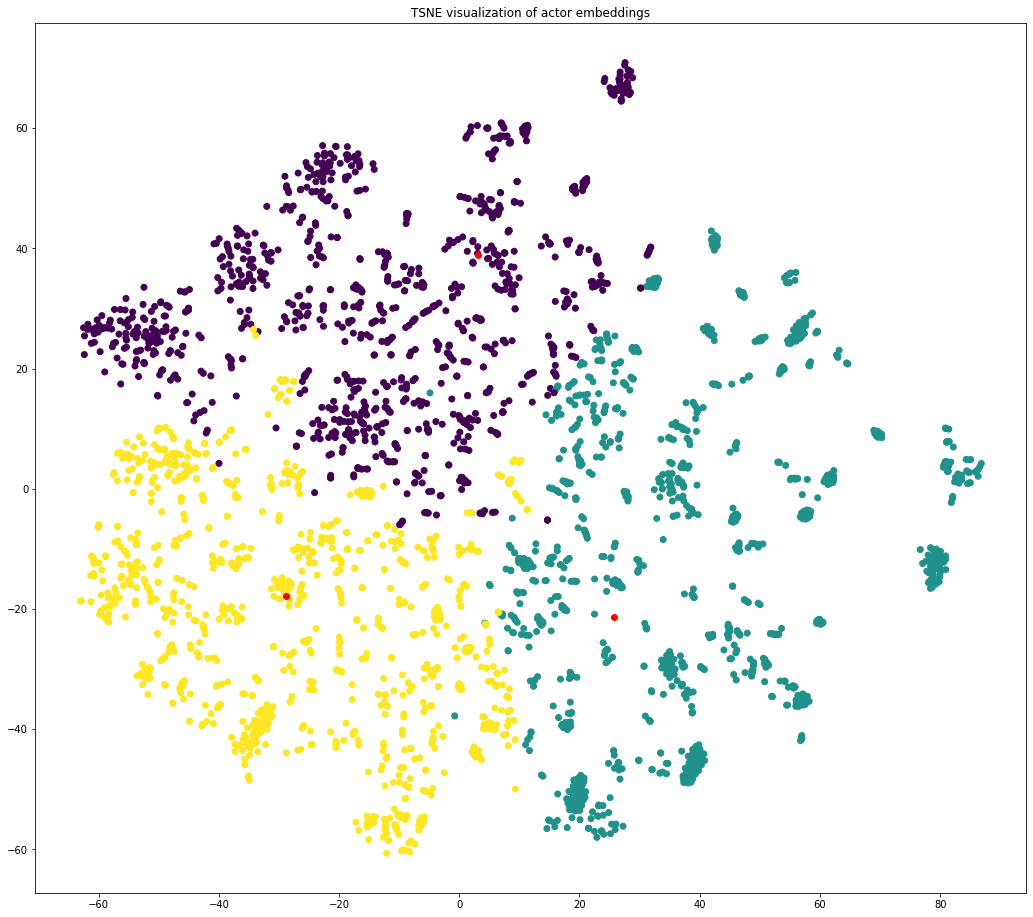

In [169]:
from sklearn.manifold import TSNE
transform = TSNE #PCA

trans = transform(n_components=2)
actor_embeddings_2d = trans.fit_transform(actor_embeddings)

import numpy as np
# draw the points

label_map = { l: i for i, l in enumerate(np.unique(kmeans.labels_))}
node_colours = [ label_map[target] for target in kmeans.labels_]

plt.figure(figsize=(20,16))
plt.axes().set(aspect="equal")
plt.scatter(actor_embeddings_2d[:,0], 
            actor_embeddings_2d[:,1], 
            c=node_colours)
plt.scatter(kmeans.cluster_centers_[:, 0], 
            kmeans.cluster_centers_[:, 1], 
            c='red')    
plt.title('{} visualization of actor embeddings'.format(transform.__name__))

plt.show()

# <font color='red'>Task 2 : Apply clustering algorithm to group similar movies</font>


1. For this task consider only the movie nodes
2. Apply any clustering algorithm of your choice
3.Choose the number of clusters for which you have maximum score of $Cost1*Cost2$ <br>

    Cost1 = $\frac{1}{N}\sum_{\text{each cluster i}}  \frac{\text{(number of nodes in the largest connected component in the graph with the movie nodes and its actor neighbours in cluster i)}}{\text{(total number of nodes in that cluster i)}}$ where N= number of clusters <br>
(Write your code in <font color='blue'>def cost1()</font>)<br>
	
4. Cost2 = $\frac{1}{N}\sum_{\text{each cluster i}}  \frac{\text{(sum of degress of movie nodes in the graph with the movie nodes and its actor neighbours in cluster i)}}{\text{(number of unique actor nodes in the graph with the movie nodes and its actor neighbours in cluster i)}}$ 
where N= number of clusters 
<br>(Write your code in <font color='blue'>def cost2()</font>)<br>


In [170]:
#info about KMeans : https://stackabuse.com/k-means-clustering-with-scikit-learn/

start = datetime.now()
final_cost = dict() #creating an empty dictionary to store cluster_number as "key" and total_cost(cost1*cost2) as "value"

for k in [3, 5, 10, 30, 50, 100, 200, 500]: #range of cluster values
   algo = KMeans(n_clusters=k,random_state=0)
   algo.fit(movie_embeddings)               # matrix of size N*d where N number of actor nodes and d is dimension from gensim

   cluster_cost1 = 0
   cluster_cost2 = 0

   for cluster_num in range(0,k): # itering through each "k-cluster" range
   # extracting particular actor_node data belonging to a label
     cluster_nodes = np.array(movie_nodes).reshape(len(movie_nodes),)[algo.labels_== cluster_num].tolist() 
     cluster_graph = nx.Graph() #empty graph

     for each_node in cluster_nodes: # iterating through each node in cluster_nodes
       cluster_graph.add_nodes_from(nx.ego_graph(B,each_node).nodes) #adding nodes to empty graph
       cluster_graph.add_edges_from(nx.ego_graph(B,each_node).edges()) #adding edges to empty graph

     cluster_cost1 = cluster_cost1 + cost1(cluster_graph, k) # after each cluster value calculating costs
     cluster_cost2 = cluster_cost2 + cost2(cluster_graph ,k)

   print(f"Total cost for cluster {k} is {cluster_cost1*cluster_cost2}")
    
   final_cost[str(k)] = cluster_cost1*cluster_cost2
print('---'*15)
kmax_cluster = max(final_cost, key=final_cost.get)
print("Number of cluster with maximum cost is ",kmax_cluster)
print("maximum cost is ",final_cost[kmax_cluster])
print('---'*15)
print(" Total time taken = " , datetime.now()-start)
   

Total cost for cluster 3 is 8.714318964836597
Total cost for cluster 5 is 10.635902760986742
Total cost for cluster 10 is 8.846442409438822
Total cost for cluster 30 is 11.79072161639957
Total cost for cluster 50 is 14.459502050176162
Total cost for cluster 100 is 13.911764337352425
Total cost for cluster 200 is 12.72465925420378
Total cost for cluster 500 is 10.34457543892231
---------------------------------------------
Number of cluster with maximum cost is  50
maximum cost is  14.459502050176162
---------------------------------------------
 Total time taken =  0:00:22.794406


<font color='blue'>Grouping similar movies</font>

In [171]:
kmeans = KMeans(n_clusters=int(kmax_cluster), random_state=0).fit(movie_embeddings)
movie_nodes=np.array(movie_nodes)
movie_data=np.vstack((movie_nodes,kmeans.labels_))
movie_df=pd.DataFrame(movie_data.T,columns=["movie_nodes","labels"])
print(movie_df.head())
print()
print('****'*15)
print( )
print(movie_df.describe())

  movie_nodes labels
0       m1094     48
1         m67     32
2       m1111     28
3       m1100     43
4       m1095     36

************************************************************

       movie_nodes labels
count         1292   1292
unique        1292     50
top          m1094      1
freq             1    201


<font color='blue'>Displaying similar movie clusters</font>

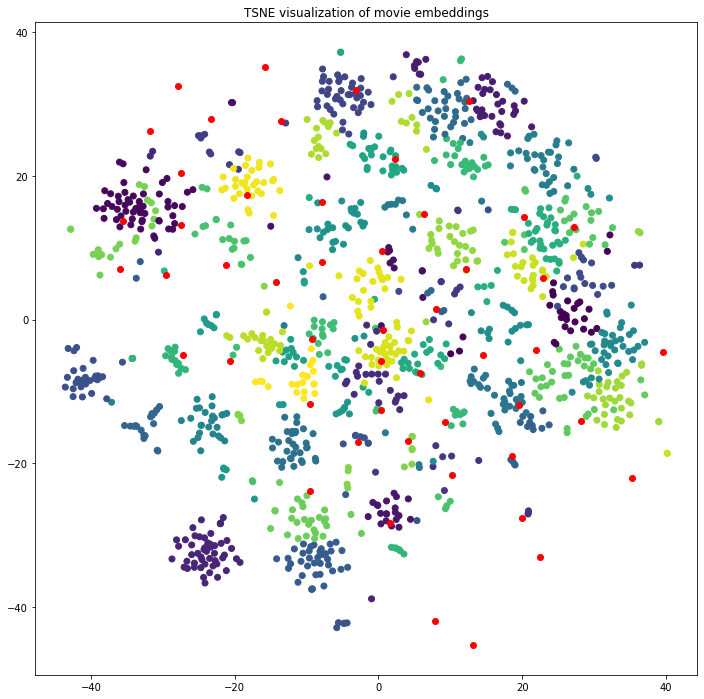

In [173]:
from sklearn.manifold import TSNE
transform = TSNE #PCA

trans = transform(n_components=2)
movie_embeddings_2d = trans.fit_transform(movie_embeddings)

import numpy as np
# draw the points

label_map = { l: i for i, l in enumerate(np.unique(kmeans.labels_))}
node_colours = [ label_map[target] for target in kmeans.labels_]

plt.figure(figsize=(12,12))
plt.axes().set(aspect="equal")
plt.scatter(movie_embeddings_2d[:,0], 
            movie_embeddings_2d[:,1], 
            c=node_colours)
plt.scatter(kmeans.cluster_centers_[:, 0], 
            kmeans.cluster_centers_[:, 1], 
            c='red')    
plt.title('{} visualization of movie embeddings'.format(transform.__name__))

plt.show()